# Trackster distances

Plot energy profiles of reco and sim tracksters.

The task gets much more difficult with the increasing overlap.

Two approaches for matching are possible:
- simtrackster that has the largest fraction of the reco trackster energy
- simtrackster in which the reco trackster makes up the largest fraction

In [1]:
import uproot
import awkward as ak
import numpy as np

import matplotlib.pyplot as plt

from reco.plotting import plot_sim_reco, plot_tracksters
from reco.dataset import match_trackster_pairs, get_ground_truth
from reco.evaluation import evaluate


# %matplotlib widget
%matplotlib inline

ds_name = "MultiParticle"
file_name = "new_ntuples_15163313_7.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

plt.style.use('seaborn-whitegrid')

file_path = f"{raw_dir}/{file_name}"
tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_path: "ticlNtuplizer/graph"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})

ev_per_file = len(tracksters["raw_em_energy"].array())
print("Events per file:", ev_per_file)

E_TH = 10 # from energy_profile

Events per file: 100


In [20]:
e_pairs = [match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    energy_threshold=E_TH,
    distance_threshold=100,
    distance_type="bary",
    confidence_threshold=0.5
) for eid in range(10)]

e_lc_pairs = [match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    energy_threshold=E_TH,
    distance_threshold=100,
    distance_type="pairwise",
    confidence_threshold=0.5
) for eid in range(10)]

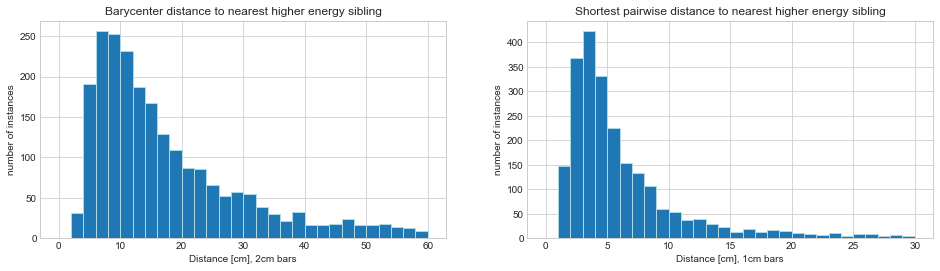

In [21]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121)
ax.hist(ak.flatten(e_pairs)[:,2], bins=30, edgecolor="lightblue", range=(0,60))
ax.set_title("Barycenter distance to nearest higher energy sibling")
ax.set_xlabel("Distance [cm], 2cm bars")
ax.set_ylabel("number of instances")

ax = fig.add_subplot(122)
ax.hist(ak.flatten(e_lc_pairs)[:,2], bins=30, edgecolor="lightblue", range=(0, 30))
ax.set_title("Shortest pairwise distance to nearest higher energy sibling")
ax.set_xlabel("Distance [cm], 1cm bars")
ax.set_ylabel("number of instances")

plt.show()

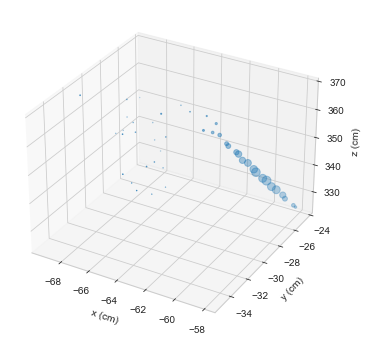

In [22]:
eid = 1
x_lc = tracksters["vertices_x"].array()[eid]
y_lc = tracksters["vertices_y"].array()[eid]
z_lc = tracksters["vertices_z"].array()[eid]
e_lc = tracksters["vertices_energy"].array()[eid]

p_id = 2
indices = [p_id]
fig = plt.figure(figsize=(6, 6))

for i, (tt, lt, dst) in enumerate(e_pairs[eid]):
    if lt == p_id:
        indices.append(tt)

ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, x_lc[indices], y_lc[indices], z_lc[indices], e_lc[indices])
plt.show()

## Geometry correction

Layers further in the detector are further away from each other.

In [19]:
z_set = set()
sim_z_lc = tracksters["vertices_z"].array()

for z_event in sim_z_lc:
    for z_trackster in z_event:
        for z_lc in z_trackster:
            z_set.add(z_lc)

In [20]:
z_list = list(sorted(z_set))
z_map = {z: i for i, z in enumerate(z_list)}

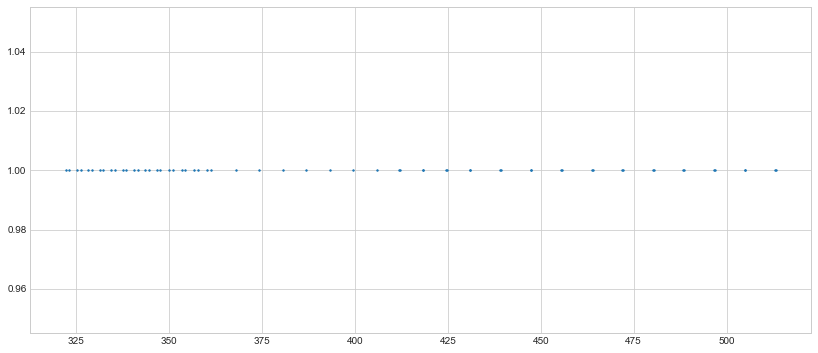

In [21]:
fig = plt.figure(figsize=(14, 6))
plt.scatter(z_list, np.ones(len(z_list)), s=2)
plt.show()

In [22]:
import pickle
from os.path import join

z_map_path = join(data_root, "z_map.pt")

with open(z_map_path, "wb") as f:
    pickle.dump(z_map, f)

In [23]:
from reco.distance import get_z_map, apply_map

z_map = get_z_map(data_root)

In [24]:
e_lc_pairs = [match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    energy_threshold=E_TH,
    distance_threshold=100,
    distance_type="pairwise",
    confidence_threshold=0.5,
    z_map=z_map
) for eid in range(5)]

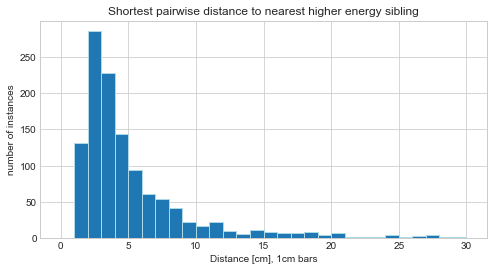

In [25]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.hist(ak.flatten(e_lc_pairs)[:,2], bins=30, edgecolor="lightblue", range=(0, 30))
ax.set_title("Shortest pairwise distance to nearest higher energy sibling")
ax.set_xlabel("Distance [cm], 1cm bars")
ax.set_ylabel("number of instances")
plt.show()

## Select the right layer distance

Look at variance in X, Y, and Z.

Idea - GNNs can do the learning themselves, no reason to pre-crunch this for them.
What is really affected by the irregular Z-geometry is the candidate cut-off.
Therefore, use the mapping for candidate selection, forget about it later.

In [27]:
x_var = []
for e_x_lc in tracksters["vertices_z"].array():
    for t_x_lc in e_x_lc:
        x_var.append(np.var(apply_map(t_x_lc, z_map, factor=1)))

In [28]:
# all trackster variances
np.mean(x_var)

10.54831871113258

- Mean variance on x: 178.442
- Mean variance on y: 176.255
- Mean variance on z: 778.284 (I mean, duuh they are elongated)
    - map with 1cm between layers: 71.982
    - map with 2cm between layers: 287.930

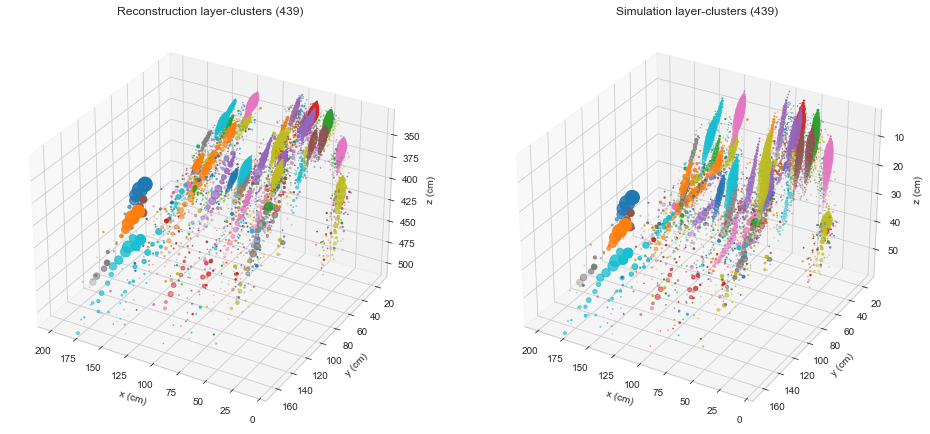

In [44]:
eid = 0
plot_sim_reco(
    tracksters["vertices_x"].array()[eid],
    tracksters["vertices_y"].array()[eid],
    tracksters["vertices_z"].array()[eid],
    tracksters["vertices_energy"].array()[eid],
    tracksters["vertices_x"].array()[eid],
    tracksters["vertices_y"].array()[eid],
    list([apply_map(tx, z_map) for tx in tracksters["vertices_z"].array()[eid]]),
    tracksters["vertices_energy"].array()[eid],
    tracksters["vertices_indexes"].array()[eid],
    tracksters["vertices_multiplicity"].array()[eid],
    legend=False,
    figsize=(16, 10),
    align_dim=False
)